# Classifying Banking Intent from Customer Queries

## Introduction

This project compares two text classification models to predict customer intent from real-world customer banking queries. The end-to-end AI workflow showcases the implementations of foundational AI and deep learning techniques, such as modern transformer-based fine-tuning approaches for natural language tasks.

We'll demonstrate and compare two language models:

* A baseline Multi-Layer Perceptron (MLP) classifier.
* A fine-tuned RoBERTa model using LoRA.

This comparison will highlight the trade-off between training efficiency/speed and model performance. While we expect the MLP to train significantly faster, we also expect fine-tuned RoBERTA to achieve superior classification performance.

### Project Goals

* Explore and visualize the Banking77 dataset.
* Implement a baseline MLP classifier.
* Fine-tune a pre-trained RoBERTa model using LoRA.
* Compare model performances (overall accuracy, mean F1-scores).
* Implement AI best practices by redacting sensitive personally identifiable information (PII).

### Dataset

**Banking77** is a text dataset containing banking customer queries labeled with an intent related to a specific banking-related action. Queries are short, natural language texts that customers might input into a chatbot.

* 77 unique intents (classification labels).
* 13,803 queries (10,003 for training and 3,080 for testing).
* Source: https://huggingface.co/datasets/PolyAI/banking77

Example query:

```py
{
  'label': 11, # integer label corresponding to "card_arrival" intent
  'text': 'I am still waiting on my card?'
}
```

### Library versions

```py
torch==2.4.1
datasets==2.14.6
numpy==1.26.4
pandas==2.2.3
scikit-learn==1.3.0
transformers==4.45.0
```

## Setup + Libraries

- Import Python modules.
- Set random seed.
- Set up GPU device.

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import torch

# Set random seed
torch.manual_seed(42)

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## Load the Data

Let's load the training and testing datasets into pandas.

- Training dataset: `"datasets/banking77_train.csv"`
- Testing dataset: `"datasets/banking77_test.csv"`

In [2]:
train = pd.read_csv("datasets/banking77_train.csv")
test = pd.read_csv("datasets/banking77_test.csv")
train.head()

,text,category
0,I am still waiting on my card?,card_arrival
1,What can I do if my card still hasn't arrived ...,card_arrival
2,I have been waiting over a week. Is the card s...,card_arrival
3,Can I track my card while it is in the process...,card_arrival
4,"How do I know if I will get my card, or if it ...",card_arrival


In [3]:
test.head()

,text,category
0,How do I locate my card?,card_arrival
1,"I still have not received my new card, I order...",card_arrival
2,I ordered a card but it has not arrived. Help ...,card_arrival
3,Is there a way to know when my card will arrive?,card_arrival
4,My card has not arrived yet.,card_arrival


### Data Characteristics

The training and testing datasets have two columns:

- `text`: The customer banking query in natural language.
- `category`: The intent category as text strings.

**Training and testing size**

In [4]:
print("Training size:", train.shape)
print("Testing size:", test.shape)

Training size: (10003, 2)
Testing size: (3080, 2)


**Number of banking intent labels**

In [5]:
print("Number of banking intent labels:", train["category"].nunique())

Number of banking intent labels: 77


**Distribution of class intent labels**

Let's visualize the distribution of intent labels (counts for each class).

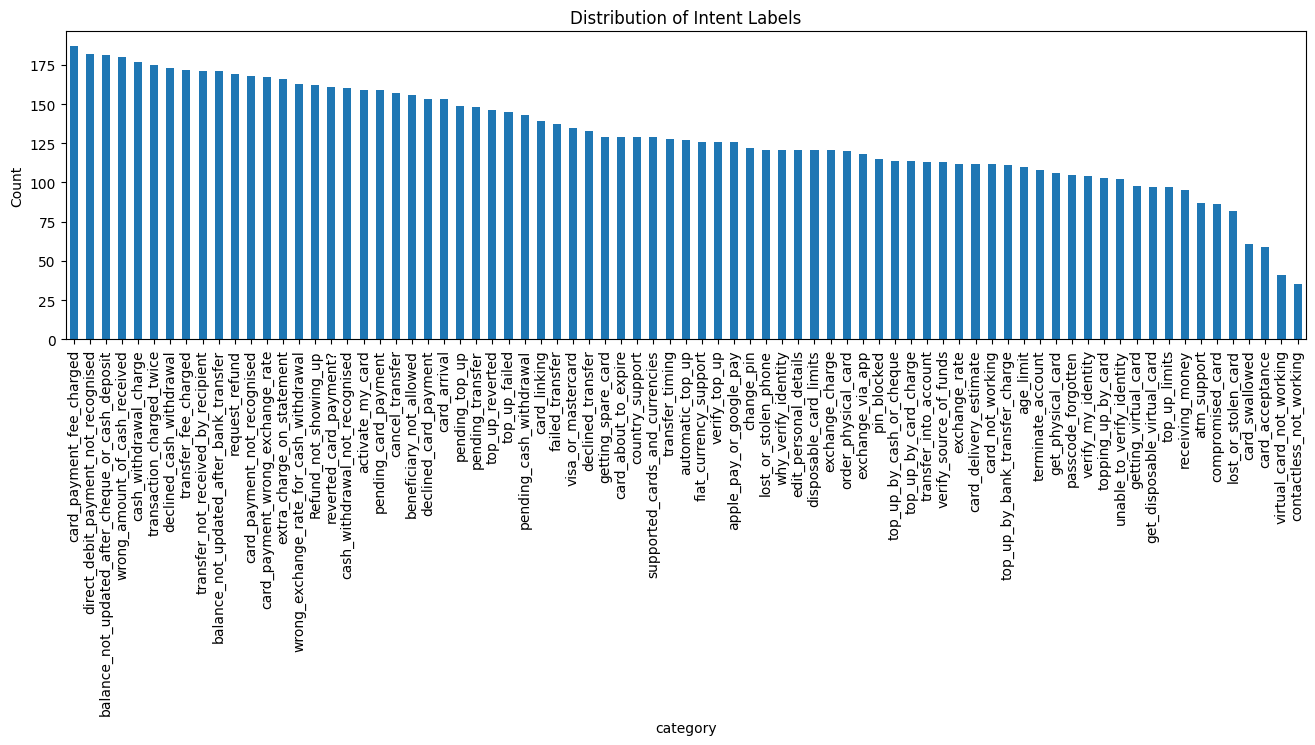

In [6]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16,4))
train["category"].value_counts().plot(kind='bar')
plt.title("Distribution of Intent Labels")
plt.xlabel("category")
plt.ylabel("Count")
plt.show()

Since there are 77 intent labels, let's visualize the top 10 most occurring.

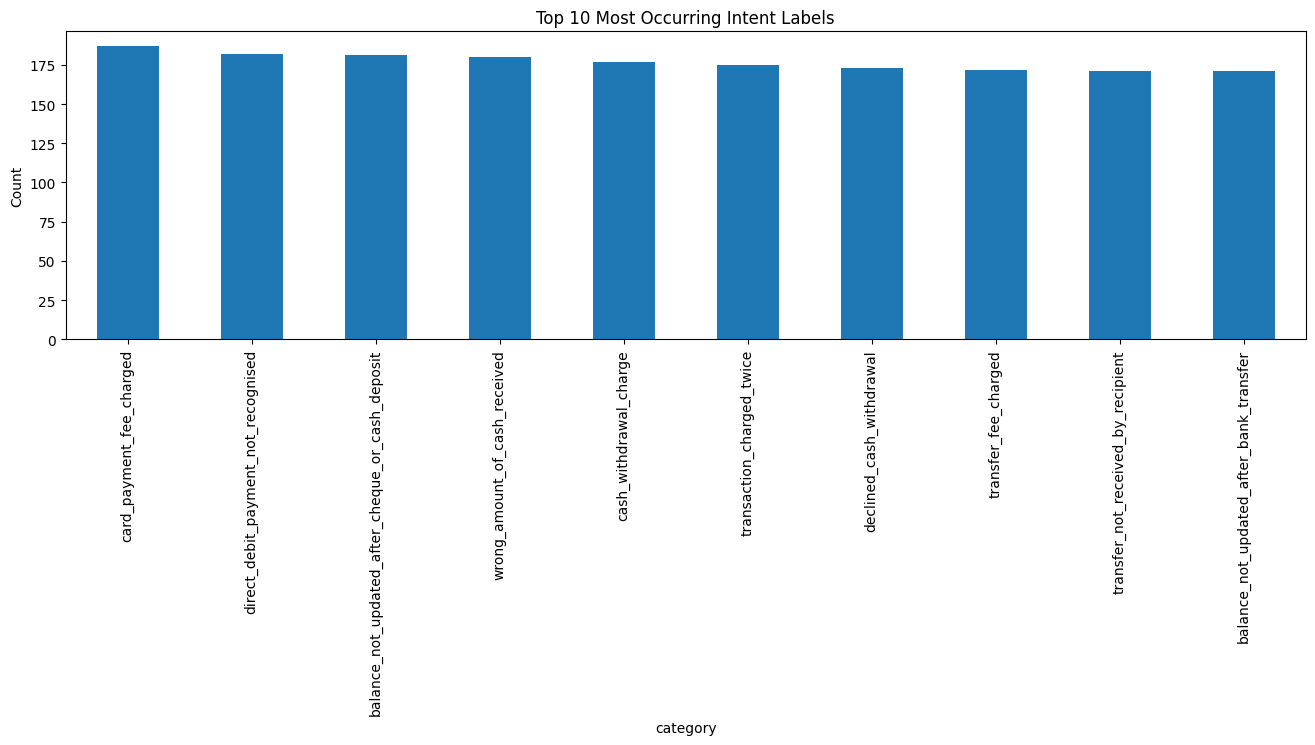

In [7]:
plt.figure(figsize=(16,4))
train["category"].value_counts().head(10).plot(kind='bar')
plt.title("Top 10 Most Occurring Intent Labels")
plt.xlabel("category")
plt.ylabel("Count")
plt.show()

The top 10 most occurring intents have a few common themes:
- Fee-related complaints: payment fees, transfer fees, and withdrawal charges.
- Transaction errors: charged twice, wrong amount received, failed transactions.
- Balance update issues: balance not updated after deposits or transfers.

**Length distribution by intent labels**

Let's visualize and compare the text lengths for the customer queries across each intent. 

<Figure size 1600x600 with 0 Axes>

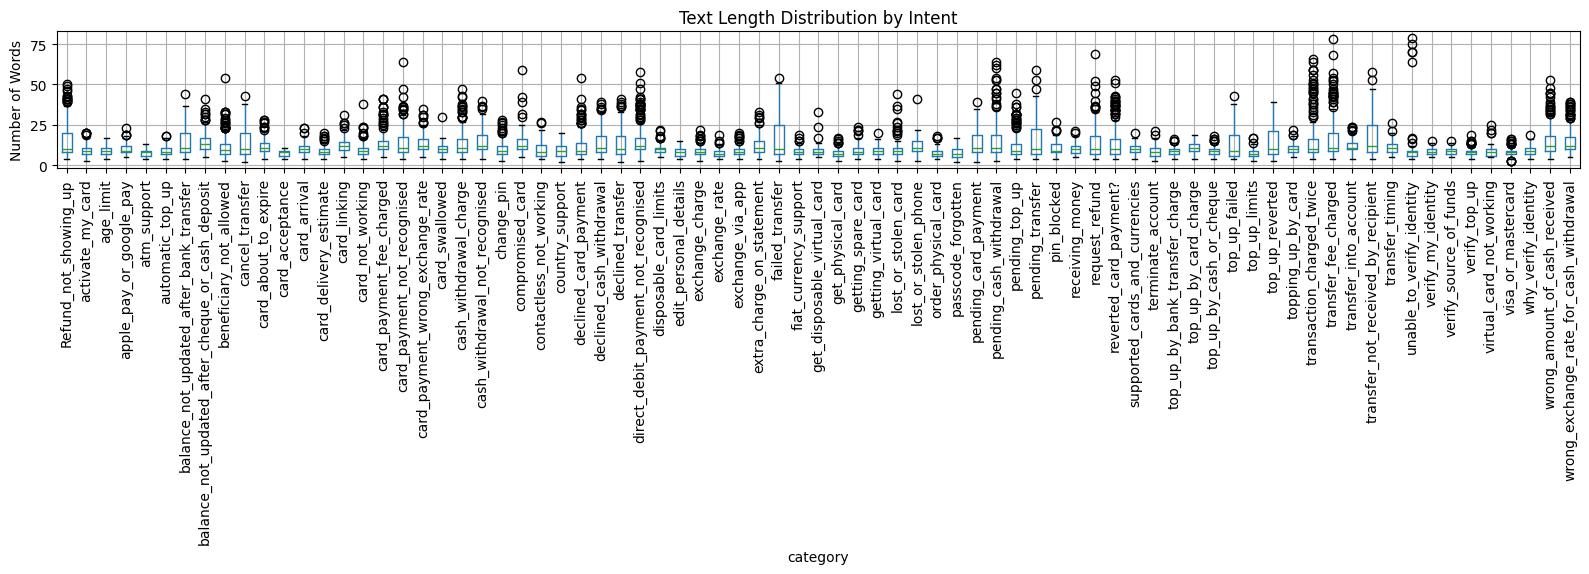

In [8]:
train['text_length'] = train['text'].str.split().str.len()

plt.figure(figsize=(16, 6))
train.boxplot(column='text_length', by='category', rot=90, figsize=(16,6))
plt.suptitle('')
plt.title('Text Length Distribution by Intent')
plt.ylabel('Number of Words')
plt.tight_layout()
plt.show()

Looking at the text length distribution, there are a few notable themes:

- The majority of customer queries are short (10-20 words) with minimal variation, which aligns with typical chatbot interactions where users ask brief, direct questions.
- Intents are all fairly uniform in their mean, median, and interquartile ranges, suggesting that customers use concise language when reporting their issues, asking questions, or making requests.
- Outliers are present in almost all intents, suggesting that some customers provide extensive details in their text inputs. 

**Visualize WordClouds**

Let's visualize word clouds for the top 6 most occurring intents. Each word cloud visually represents the text data, where individual words are displayed with text sizes proportional to how frequently they appear in each intent. Words that occur more often are larger, which helps us understand what kinds of words characterize different intents.

In [9]:
train['category'].value_counts().head(6)

category
card_payment_fee_charged                            187
direct_debit_payment_not_recognised                 182
balance_not_updated_after_cheque_or_cash_deposit    181
wrong_amount_of_cash_received                       180
cash_withdrawal_charge                              177
transaction_charged_twice                           175
Name: count, dtype: int64

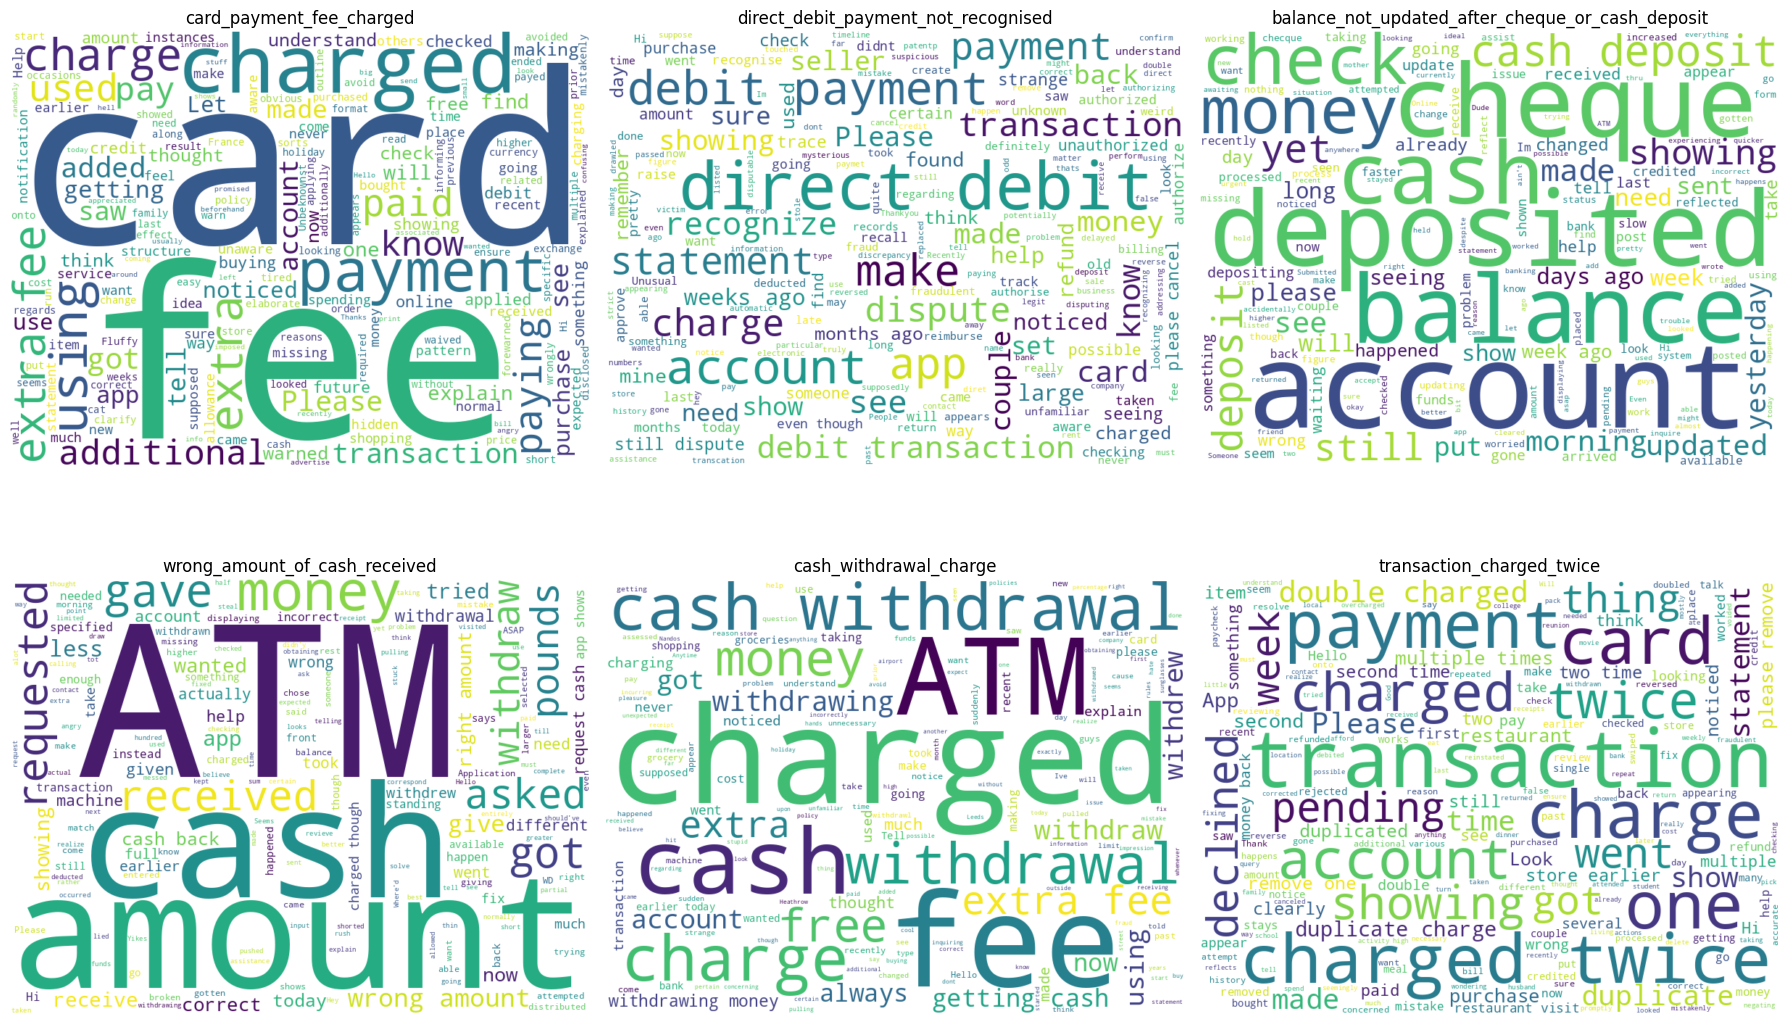

In [10]:
from wordcloud import WordCloud
import numpy as np

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
top_intents = train['category'].value_counts().head(6).index

for idx, intent in enumerate(top_intents):
    ax = axes[idx // 3, idx % 3]
    text = ' '.join(train[train['category'] == intent]['text'])

    # Generate word clouds
    wordcloud = WordCloud(width=800, height=600, 
                         background_color='white').generate(text)
    
    ax.imshow(np.array(wordcloud.to_image()), interpolation='bilinear')
    ax.set_title(intent, fontsize=12)
    ax.axis('off')
    
plt.tight_layout()
plt.show()

There are several interesting themes while looking at these word clouds:
- Strong lexical alignment with intent labels: dominant words closely mirror the intent name itself.
- Strong vocabulary overlap across intents: words like `charged`, `account`, and `money` are very common.
- Temporal language helps distinguish intents: many intents prominently feature time-related words like `today`, `pending`, `waiting`.
- Fine-grained distinctions: Some intents differ by a few critical words like `cash` vs `card` and `deposit` vs `balance`.

Why might this matter for our text classification models?
- The task may rely on identifying nuanced lexical cue keywords rather than deep banking knowledge. This means our baseline MLP might achieve decent accuracy.
- Intents are keyword-rich, but highly overlapping. We might expect the MLP to struggle here, but the fine-tuned RoBERTa to excel when utilizing its contextual embeddings for understanding.


## Baseline Multi-Layer Perceptron (MLP)

As a first modeling step, we'll build and train a Multi-Layer Perceptron (MLP) to serve as a **baseline text classifier**.

The purpose of this baseline is to:
- Create a benchmark to compare against more advanced models (e.g., transformers).
- Provide a strong non-contextual reference point for text classification performance.

### Preprocessing: Encode Class Labels with `LabelEncoder`

Convert the categorical intent labels from text strings into integer-encoded values:
- Each unique intent category is mapped to a unique integer ID.
- Fit on the training dataset and apply to the test dataset.

In [11]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train = le.fit_transform(train["category"].astype(str).values)
y_test  = le.transform(test["category"].astype(str).values)

num_classes = len(le.classes_)
print("num_classes:", num_classes)

num_classes: 77


### Preprocessing: Extract and Vectorize Text Features with `TfidfVectorizer`

To train the MLP, we'll represent each text as **TF-IDF (Term Frequency-Inverse Document Frequency)** features.
- TF-IDF converts each text into vectors that represent how important a word is in a given text relative to the full text corpus.

Preprocessing steps:
- Fit and transform on the training dataset.
- Transform the testing dataset using learned features from the training dataset.

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(
    lowercase=True,
    ngram_range=(1, 2),
    min_df=2,
    max_df=0.95,
    max_features=50_000,
    strip_accents="unicode",
)

# Fit + transform training dataset, transform testing dataset
X_train = tfidf.fit_transform(train["text"].astype(str).values)
X_test  = tfidf.transform(test["text"].astype(str).values)

input_size = X_train.shape[1]
print("input_size:", input_size)

input_size: 10292


### Preprocessing: Create TF-IDF Dataset

Because PyTorch models expect data to be provided through a `Dataset` class, we define a custom dataset class that:

- Wraps sparse TF-IDF feature matrices.
- Converts sparse rows into dense tensors.
- Returns input–label pairs for training.

In [13]:
from torch.utils.data import Dataset, DataLoader

class TfidfDataset(Dataset):
    def __init__(self, X_sparse, y):
        self.X = X_sparse
        self.y = y

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        x = self.X[idx].toarray().astype(np.float32).squeeze(0)
        y = np.int64(self.y[idx])
        return torch.from_numpy(x), torch.tensor(y)

train_ds = TfidfDataset(X_train, y_train)
test_ds  = TfidfDataset(X_test, y_test)

### Preprocessing: Create DataLoaders

Batch the training and testing dataset queries into batches using PyTorch `DataLoader` objects.

In [14]:
train_loader = DataLoader(train_ds, batch_size=256, shuffle=True)
test_loader  = DataLoader(test_ds, batch_size=512, shuffle=False)

### Build MLP Architecture

The architecture consists of:
- An **input layer** matching the dimensionality of the TF-IDF vectors.
- Two **hidden layers** with ReLU activations to introduce non-linearities.
- An **output layer** that produces predicted outputs (logits) for each of the 77 intent classes.

In [15]:
import torch
import torch.nn as nn

class SimpleMLP(nn.Module):
    def __init__(self, input_size: int, hidden_size=512, output_size=77):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

### Instantiate MLP, Loss Function, and Optimizer

We'll create an instance of the MLP and initialize the following:
 - **Cross-Entropy Loss** is selected for multi-class classification.
 - **AdamW optimizer** to update model parameters using adaptive learning rates with weight decay.

In [16]:
import torch.nn.functional as F

model = SimpleMLP(
    input_size=input_size,
    hidden_size=512,
    output_size=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)

### Train MLP on the Training Set

Next, we'll create a training function that trains the MLP that includes:
- Training parameters (number of epochs).
- Looping through the training batches.
- Calculating the loss through the forward pass.
- Updating weight values through the backward pass.
- Calculating training performance metrics per epoch.

In [17]:
torch.manual_seed(42)

def train_model(
    model,
    train_loader,
    loss_fn,
    optimizer,
    num_epochs: int = 5,
    device: torch.device = None,
):
    if device is None:
        device = next(model.parameters()).device

    model.train()

    for epoch in range(num_epochs):
        epoch_loss = 0.0
        correct = 0
        total = 0
        num_batches = 0

        for batch_X, batch_y in train_loader:
            batch_X = batch_X.to(device)
            batch_y = batch_y.to(device)

            # Forward Pass
            logits = model(batch_X)
            loss = loss_fn(logits, batch_y)

            # Backward Pass
            optimizer.zero_grad(set_to_none=True)
            loss.backward()
            optimizer.step()

            # Training predictions
            epoch_loss += loss.item()
            num_batches += 1
            preds = logits.argmax(dim=1)
            correct += (preds == batch_y).sum().item()
            total += batch_y.size(0)

        # Metrics
        avg_loss = epoch_loss / num_batches
        accuracy = correct / total

        print(
            f"Epoch [{epoch + 1}/{num_epochs}] | "
            f"Loss: {avg_loss:.4f} | "
            f"Accuracy: {accuracy:.4f}"
        )

# Train model
train_model(
    model=model,
    train_loader=train_loader,
    loss_fn=criterion,
    optimizer=optimizer,
    num_epochs=5,
    device=device,
)

Epoch [1/5] | Loss: 4.1448 | Accuracy: 0.0865
Epoch [2/5] | Loss: 2.4702 | Accuracy: 0.5647
Epoch [3/5] | Loss: 0.6512 | Accuracy: 0.8703
Epoch [4/5] | Loss: 0.2422 | Accuracy: 0.9499
Epoch [5/5] | Loss: 0.1220 | Accuracy: 0.9789


### Evaluate MLP on the Testing Dataset

Let's create a prediction function that builds a prediction loop to generate predictions on the testing set. The function will return the model's predictions and its actual label.

In [18]:
def predict(model, dataloader, device="cpu"):
    model.eval()

    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for batch_X, batch_y in dataloader:
            batch_X = batch_X.to(device)
            batch_y = batch_y.to(device)

            logits = model(batch_X)
            preds = logits.argmax(dim=1)

            all_predictions.append(preds.cpu().numpy())
            all_labels.append(batch_y.cpu().numpy())

    y_pred = np.concatenate(all_predictions)
    y_true = np.concatenate(all_labels)
    return y_pred, y_true

# Generate test predictions
mlp_y_pred, mlp_y_true = predict(
    model=model,
    dataloader=test_loader,
    device=device,
)

### Classification Report: MLP

We'll evaluate the testing predictions by generating a classification report that allows us to see for each intent class:
- Precision
- Recall
- F1-Score

As well as aggregated statistics:
- The overall accuracy across all intents.
- Macro-average precision, recall, and F1 score (how well the model performs across all intents equally).
- Weighted-average precision, recall, and F1 score (how well the model performs across all intents weighted by class sizes).

In [19]:
from sklearn.metrics import accuracy_score, f1_score, classification_report
mlp_accuracy = accuracy_score(mlp_y_true, mlp_y_pred)
mlp_macro_f1 = f1_score(mlp_y_true, mlp_y_pred, average='macro')
mlp_weighted_f1 = f1_score(mlp_y_true, mlp_y_pred, average='weighted')
mlp_report = classification_report(mlp_y_true, mlp_y_pred, target_names=le.classes_)

print("=== Baseline MLP Performance ===")
print(f"Overall Accuracy Score: {mlp_accuracy:.4f}")
print(f"Macro F1: {mlp_macro_f1:.4f}")
print(f"Weighted F1: {mlp_weighted_f1:.4f}")
print("\nClassification report:")
print(mlp_report)

=== Baseline MLP Performance ===
Overall Accuracy Score: 0.8799
Macro F1: 0.8797
Weighted F1: 0.8797

Classification report:
                                                  precision    recall  f1-score   support

                           Refund_not_showing_up       0.95      0.90      0.92        40
                                activate_my_card       1.00      0.97      0.99        40
                                       age_limit       1.00      1.00      1.00        40
                         apple_pay_or_google_pay       1.00      1.00      1.00        40
                                     atm_support       0.86      0.95      0.90        40
                                automatic_top_up       0.97      0.88      0.92        40
         balance_not_updated_after_bank_transfer       0.67      0.75      0.71        40
balance_not_updated_after_cheque_or_cash_deposit       0.97      0.90      0.94        40
                         beneficiary_not_allowed       0.90     

## Finetune RoBERTa with LoRA

In this section, we'll finetune a **pretrained RoBERTa transformer** using **LoRA** (Low-Rank Adaptation).

- RoBERTa provides contextualized token embeddings that enable the model to better capture contextual information and semantic differences between intent classes that our baseline MLP might have struggled to understand. 
- LoRA helps us use trainable adapters to significantly reduce the computational cost of finetuning while preserving performance. 
- We expect finetuning to still be slower than training the MLP, but expect the classification performance of LoRA-RoBERTa to be better.

But first, let's reload a clean version of the training and testing datasets.

In [20]:
import pandas as pd
train = pd.read_csv("datasets/banking77_train.csv")
test = pd.read_csv("datasets/banking77_test.csv")
train.head()

,text,category
0,I am still waiting on my card?,card_arrival
1,What can I do if my card still hasn't arrived ...,card_arrival
2,I have been waiting over a week. Is the card s...,card_arrival
3,Can I track my card while it is in the process...,card_arrival
4,"How do I know if I will get my card, or if it ...",card_arrival


### Preprocessing: Encode Class Labels with `LabelEncoder`

Similar to before, convert the categorical intent labels from text strings into integer-encoded values:
- Each unique intent category is mapped to a unique integer ID.
- Fit on the training dataset and apply to the test dataset.

We'll create a new label encoder separate from the one used for the MLP.

In [21]:
from datasets import Dataset
from sklearn.preprocessing import LabelEncoder

train = train.dropna(subset=["text", "category"]).copy()
test = test.dropna(subset=["text", "category"]).copy()

label_encoder = LabelEncoder()
train["labels"] = label_encoder.fit_transform(train["category"].astype(str))
test["labels"]  = label_encoder.transform(test["category"].astype(str))

num_classes = len(label_encoder.classes_)
print("num_classes:", num_classes)

training_set = Dataset.from_pandas(train[["text", "labels"]], preserve_index=False)
test_set     = Dataset.from_pandas(test[["text", "labels"]], preserve_index=False)

num_classes: 77


### Preprocessing: Tokenization Using RoBERTa Tokenizer

Use the RoBERTa tokenizer `roberta-base` to convert raw text queries into subword-based tokens: 
- Truncate text to cap sequence length.
- Set max token length to **256** tokens.
- Apply dynamic padding using `DataCollatorWithPadding`, which pads sequences based on the longest sequence within each batch.

In [22]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, DataCollatorWithPadding
tokenizer = AutoTokenizer.from_pretrained("roberta-base")

def tokenize_function(examples):
    return tokenizer(examples["text"], truncation=True, max_length=256)

tokenized_training_set = training_set.map(tokenize_function, batched=True)
tokenized_test_set     = test_set.map(tokenize_function, batched=True)

cols_to_keep = {"input_ids", "attention_mask", "labels"}
tokenized_training_set = tokenized_training_set.remove_columns(
    [c for c in tokenized_training_set.column_names if c not in cols_to_keep]
)
tokenized_test_set = tokenized_test_set.remove_columns(
    [c for c in tokenized_test_set.column_names if c not in cols_to_keep]
)

# Data collator
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

Map: 100%|██████████| 3080/3080 [00:00<00:00, 52249.40 examples/s]


### Set Up Finetuning Configuration

Next, we configure the transformer finetuning process using Hugging Face's `TrainingArguments` module.

Key training, evaluation, and optimization settings include:
- The learning rate is set with a learning rate scheduler.
- The number of finetuning epochs.
- Generating per epoch evaluation and logging.
- Batch sizes tuned for training and evaluation.
- Fixed random seed for reproducibility

In [23]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./temp_results",
    save_strategy="no",
    logging_dir="./logs",
    evaluation_strategy="epoch",
    logging_strategy="epoch",
    report_to="none",

    learning_rate=2e-4,
    lr_scheduler_type="cosine",
    warmup_ratio=0.1,
    num_train_epochs=10,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    seed=42,
)

### Configure LoRA for Parameter-Efficient Finetuning

Next, we'll configure and apply LoRA to efficiently finetune RoBERTa using the `PEFT` library. 

In this step:
- We select a pretrained RoBERTa (`roberta-base`) as the base model.
- Configure LoRA for the classification of sequences.
- Adapters are applied to query, key, and value projections within the self-attention mechanism.
- Instantiate the model.
- Set the model to the GPU device.

LoRA hyperparameters:
- Set rank to `r=32`.
- Set scaling factor to `lora_alpha=64`.
- Set dropout to `lora_dropout=0.05`.
- Set no bias update.

In [24]:
from peft import LoraConfig, get_peft_model, TaskType
torch.manual_seed(42)

model = AutoModelForSequenceClassification.from_pretrained(
    "roberta-base",
    num_labels=num_classes
).to(device)

lora_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    r=32,
    lora_alpha=64,
    lora_dropout=0.05,
    bias="none",
    target_modules=["query", "key", "value"],
)

model = get_peft_model(model, lora_config)
model.print_trainable_parameters()
model.to(device)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 2,419,277 || all params: 127,124,122 || trainable%: 1.903082563669545


PeftModelForSequenceClassification(
  (base_model): LoraModel(
    (model): RobertaForSequenceClassification(
      (roberta): RobertaModel(
        (embeddings): RobertaEmbeddings(
          (word_embeddings): Embedding(50265, 768, padding_idx=1)
          (position_embeddings): Embedding(514, 768, padding_idx=1)
          (token_type_embeddings): Embedding(1, 768)
          (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (encoder): RobertaEncoder(
          (layer): ModuleList(
            (0-11): 12 x RobertaLayer(
              (attention): RobertaAttention(
                (self): RobertaSdpaSelfAttention(
                  (query): lora.Linear(
                    (base_layer): Linear(in_features=768, out_features=768, bias=True)
                    (lora_dropout): ModuleDict(
                      (default): Dropout(p=0.05, inplace=False)
                    )
                    (lora_A): Mo

### Finetune and Evaluate the LoRA-RoBERTa Model

We'll use Hugging Face's `Trainer` module to manage the finetuning and evaluation process by passing along the training components we defined earlier:
- The LoRA-RoBERTa model and tokenizer.
- Training arguments (# of epochs, learning rate, etc.).
- Tokenized training and testing datasets.
- Evaluating and logging performance metrics.

In [25]:
from transformers import Trainer
torch.manual_seed(42)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_training_set,
    eval_dataset=tokenized_test_set,
    tokenizer=tokenizer,
    data_collator=data_collator,
)

trainer.train()
eval_metrics = trainer.evaluate()
print(eval_metrics)

Epoch,Training Loss,Validation Loss
1,2.852200,0.809174
2,0.575900,0.389433
3,0.337500,0.291915
4,0.247800,0.266578
5,0.190000,0.255143
6,0.142800,0.267585
7,0.111700,0.256233
8,0.092400,0.251141
9,0.078700,0.252071
10,0.069400,0.252469


{'eval_loss': 0.25246864557266235, 'eval_runtime': 39.7566, 'eval_samples_per_second': 77.471, 'eval_steps_per_second': 2.44, 'epoch': 10.0}


### Save Finetuned LoRA-RoBERTa

After finetuning is completed, we'll save the resulting finetuned LoRA-RoBERTa model along with the tokenizer.
- `merge_and_unload()` merges the LoRA adapter weights into the original RoBERTa model parameters.
- `save_pretrained()` saves the model configuration and weights.

In [26]:
save_dir = "./finetuned_roberta_lora_model"

model = model.merge_and_unload()
model.save_pretrained(save_dir)
tokenizer.save_pretrained(save_dir)

('./finetuned_roberta_lora_model\\tokenizer_config.json',
 './finetuned_roberta_lora_model\\special_tokens_map.json',
 './finetuned_roberta_lora_model\\vocab.json',
 './finetuned_roberta_lora_model\\merges.txt',
 './finetuned_roberta_lora_model\\added_tokens.json',
 './finetuned_roberta_lora_model\\tokenizer.json')

### Load the Finetuned LoRA-RoBERTa

- Load the finetuned LoRA-RoBERTa weights.
- Load the tokenizer.
- Set the model to evaluation mode.
- Set the model to the GPU device.

In [27]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

path = "./finetuned_roberta_lora_model"
tokenizer = AutoTokenizer.from_pretrained(path)
model = AutoModelForSequenceClassification.from_pretrained(path).to(device)
model.eval()

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

### Evaluate the Finetuned LoRA-RoBERTa on the Testing Dataset

Let's generate predictions on the testing set from the finetuned LoRA-RoBERTa model.

In [28]:
from transformers import Trainer, TrainingArguments, DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

prediction_args = TrainingArguments(
    output_dir="./temp_predictions", 
    per_device_eval_batch_size=32,    
    report_to="none",                  
)

predictor = Trainer(
    model=model,
    args=prediction_args, 
    tokenizer=tokenizer,
    data_collator=data_collator,
)

# Generate testing predictions
roberta_pred_output = predictor.predict(tokenized_test_set)
roberta_y_pred = np.argmax(roberta_pred_output.predictions, axis=1)
roberta_y_true = roberta_pred_output.label_ids

### Classification Report: Finetuned LoRA-RoBERTa

Let's evaluate the finetuned LoRA-RoBERTa by generating a classification report on the testing set predictions.

In [29]:
from sklearn.metrics import accuracy_score, f1_score, classification_report
lora_roberta_accuracy = accuracy_score(roberta_y_true, roberta_y_pred)
lora_roberta_macro_f1 = f1_score(roberta_y_true, roberta_y_pred, average='macro')
lora_roberta_weighted_f1 = f1_score(roberta_y_true, roberta_y_pred, average='weighted')
lora_roberta_report = classification_report(roberta_y_true, roberta_y_pred, target_names=label_encoder.classes_)

print("=== Finetuned RoBERTa + LoRA Performance ===")
print(f"Overall Accuracy Score: {lora_roberta_accuracy:.4f}")
print(f"Macro F1: {lora_roberta_macro_f1:.4f}")
print(f"Weighted F1: {lora_roberta_weighted_f1:.4f}")
print("\nClassification report:")
print(lora_roberta_report)

=== Finetuned RoBERTa + LoRA Performance ===
Overall Accuracy Score: 0.9347
Macro F1: 0.9347
Weighted F1: 0.9347

Classification report:
                                                  precision    recall  f1-score   support

                           Refund_not_showing_up       0.97      0.95      0.96        40
                                activate_my_card       0.97      0.97      0.97        40
                                       age_limit       1.00      1.00      1.00        40
                         apple_pay_or_google_pay       1.00      1.00      1.00        40
                                     atm_support       1.00      1.00      1.00        40
                                automatic_top_up       0.97      0.95      0.96        40
         balance_not_updated_after_bank_transfer       0.79      0.78      0.78        40
balance_not_updated_after_cheque_or_cash_deposit       1.00      0.93      0.96        40
                         beneficiary_not_allowed    

### Compare Performances

We'll compare the performance metrics of the baseline MLP against the finetuned LoRA-RoBERTa by:
- Re-generating classification reports (as dictionaries).
- Extracting per-class metrics.
- Create a new comparison DataFrame.

In [30]:
mlp_report_dict = classification_report(mlp_y_true, mlp_y_pred, target_names=le.classes_, output_dict=True)
roberta_report_dict = classification_report(roberta_y_true, roberta_y_pred, target_names=label_encoder.classes_, output_dict=True)

# Extract per-class metrics from classification reports
def extract_class_metrics(report_dict):
    class_metrics = {}
    for intent, metrics in report_dict.items():
        # Skip aggregate metrics (accuracy, macro avg, weighted avg)
        if intent not in ['accuracy', 'macro avg', 'weighted avg']:
            class_metrics[intent] = {
                'precision': metrics['precision'],
                'recall': metrics['recall'],
                'f1-score': metrics['f1-score'],
                'support': metrics['support']
            }
    return pd.DataFrame(class_metrics).T

# Create DataFrames for each model
mlp_df = extract_class_metrics(mlp_report_dict)
roberta_df = extract_class_metrics(roberta_report_dict)

# Create comparison DataFrame (optionally add recall/precision scores)
comparison_df = pd.DataFrame({
     'MLP_Precision': mlp_df['precision'],
     'RoBERTa_Precision': roberta_df['precision'],
     'MLP_Recall': mlp_df['recall'],
     'RoBERTa_Recall': roberta_df['recall'],
     'MLP_F1': mlp_df['f1-score'],
     'RoBERTa_F1': roberta_df['f1-score'],
     'Precision_Diff': roberta_df['precision'] - mlp_df['precision'],
     'Recall_Diff': roberta_df['recall'] - mlp_df['recall'],
     'F1_Diff': roberta_df['f1-score'] - mlp_df['f1-score'],
})

# Sort by F1 difference
comparison_df = comparison_df.sort_values('F1_Diff', ascending=False)
comparison_df.head(10)

,MLP_Precision,RoBERTa_Precision,MLP_Recall,RoBERTa_Recall,MLP_F1,RoBERTa_F1,Precision_Diff,Recall_Diff,F1_Diff
contactless_not_working,0.894737,1.000000,0.425,0.925,0.576271,0.961039,0.105263,0.500,0.384768
card_not_working,0.548387,0.883721,0.850,0.950,0.666667,0.915663,0.335334,0.100,0.248996
verify_my_identity,0.787879,0.906977,0.650,0.975,0.712329,0.939759,0.119098,0.325,0.227430
why_verify_identity,0.755556,0.951220,0.850,0.975,0.800000,0.962963,0.195664,0.125,0.162963
unable_to_verify_identity,0.804878,1.000000,0.825,0.925,0.814815,0.961039,0.195122,0.100,0.146224
extra_charge_on_statement,0.809524,0.974359,0.850,0.950,0.829268,0.962025,0.164835,0.100,0.132757
virtual_card_not_working,0.966667,1.000000,0.725,0.900,0.828571,0.947368,0.033333,0.175,0.118797
pending_top_up,0.965517,0.904762,0.700,0.950,0.811594,0.926829,-0.060755,0.250,0.115235
transfer_fee_charged,0.777778,0.948718,0.875,0.925,0.823529,0.936709,0.170940,0.050,0.113179
card_payment_not_recognised,0.882353,0.947368,0.750,0.900,0.810811,0.923077,0.065015,0.150,0.112266


In [38]:
comparison_df.tail(10)

,MLP_Precision,RoBERTa_Precision,MLP_Recall,RoBERTa_Recall,MLP_F1,RoBERTa_F1,Precision_Diff,Recall_Diff,F1_Diff
age_limit,1.000000,1.000000,1.000,1.000,1.000000,1.000000,0.000000,0.000,0.000000
top_up_by_card_charge,0.926829,0.926829,0.950,0.950,0.938272,0.938272,0.000000,0.000,0.000000
declined_card_payment,0.818182,0.775510,0.900,0.950,0.857143,0.853933,-0.042672,0.050,-0.003210
transaction_charged_twice,0.951220,0.909091,0.975,1.000,0.962963,0.952381,-0.042129,0.025,-0.010582
card_about_to_expire,1.000000,0.951220,0.950,0.975,0.974359,0.962963,-0.048780,0.025,-0.011396
activate_my_card,1.000000,0.975000,0.975,0.975,0.987342,0.975000,-0.025000,0.000,-0.012342
visa_or_mastercard,1.000000,1.000000,0.925,0.900,0.961039,0.947368,0.000000,-0.025,-0.013671
card_arrival,0.860465,0.875000,0.925,0.875,0.891566,0.875000,0.014535,-0.050,-0.016566
cash_withdrawal_charge,1.000000,0.925000,0.900,0.925,0.947368,0.925000,-0.075000,0.025,-0.022368
card_payment_fee_charged,1.000000,0.863636,0.875,0.950,0.933333,0.904762,-0.136364,0.075,-0.028571


#### Compare the Top/Bottom 10 Intents 

In [36]:
print("====================== Top 10 F1 Diff ======================")
print(comparison_df['F1_Diff'].head(10))
print()
print("==================== Bottom 10 F1 Diff =====================")
print(comparison_df['F1_Diff'].tail(10))

====================== Top 10 F1 Diff ======================
contactless_not_working        0.384768
card_not_working               0.248996
verify_my_identity             0.227430
why_verify_identity            0.162963
unable_to_verify_identity      0.146224
extra_charge_on_statement      0.132757
virtual_card_not_working       0.118797
pending_top_up                 0.115235
transfer_fee_charged           0.113179
card_payment_not_recognised    0.112266
Name: F1_Diff, dtype: float64

==================== Bottom 10 F1 Diff =====================
age_limit                    0.000000
top_up_by_card_charge        0.000000
declined_card_payment       -0.003210
transaction_charged_twice   -0.010582
card_about_to_expire        -0.011396
activate_my_card            -0.012342
visa_or_mastercard          -0.013671
card_arrival                -0.016566
cash_withdrawal_charge      -0.022368
card_payment_fee_charged    -0.028571
Name: F1_Diff, dtype: float64


## Performance Comparison: MLP and the Finetuned LoRA-RoBERTa

Both models achieve fairly strong performance on the Banking77 dataset.

The baseline MLP establishes a strong baseline with an overall accuracy of 88%. As expected, the finetuned LoRA-RoBERTa outperforms the MLP across all performance metrics. Specifically, the gain in the overall accuracy and macro/weighted F1 scores is substantially meaningful:

| Model          | Accuracy  | Macro F1  | Weighted F1 | 
| -------------- | --------- | --------- | ----------- |
| MLP (baseline) | 0.8799    | 0.8797      | 0.8797    |
| LoRA-RoBERTa | 0.9347 | 0.9347 | 0.9347  |

### Macro F1 Scores

Since Banking77 is multi-class (77 intents) and is balanced in the testing set (40 samples per class), macro F1 is the primary metric we'll look at to effectively compare models. Macro F1 is the unweighted average F1-scores calculated per intent class, ignoring class frequency by weighting each class equally.

$$\text{Macro F1} = \frac{1}{N} \sum_{i=1}^{N} F1_i$$

The F1 score for each class is the harmonic mean of precision and recall:

$$F1_i = 2 \cdot \frac{\text{Precision}_i \cdot \text{Recall}_i}{\text{Precision}_i + \text{Recall}_i}$$


The finetuned LoRA-RoBERTa models achieve a +5.48% gain in macro F1 score over the MLP (93.47% vs 87.97%), indicating uniform improvement across nearly all 77 intent classes. 

This benefits our model in production, where:
- Less frequent but high-stakes queries like `compromised_card`, `lost_or_stolen_card` are identified better.
- Consistent customer experience across all different types of banking queries.

### Intent-Level F1 Score Performance

The largest F1 score improvements center around two themes:

1. Card Issues
    - `contactless_not_working`: The MLP struggled heavily (57.6%) compared to LoRA-RoBERTa (96.1%).
    - `card_not_working`: The MLP struggled heavily (66.7%) compared to LoRA-RoBERTa (91.6%).

2. Identity Verification
    - `verify_my_identity`: The MLP was decent (71.6%) but was outperformed by LoRA-RoBERTa (94.0%).
    - `unable_to_verify_identity`: The MLP was decent (81.5%) but was outperformed by LoRA-RoBERTa (96.1%).
    - `why_verify_identity`: The MLP was decent (80.0%) but was outperformed by LoRA-RoBERTa (96.3%).

Observing intents where F1 scores did not improve:
- 8 intents had small performance losses (<3%).
- However, both models have excellent performance (F1 scores >=85%) across the 8 intents.
- Minor MLP advantages could probably be due to random variation, overfitting, or LoRA-RoBERTa's overcomplexity. 

### Summary

- RoBERTa + LoRA achieved 93.47% accuracy and 93.47% F1 score, representing state-of-the-art performance for the Banking77 multi-class classification task.
- The baseline MLP achieved 87.99% accuracy and 87.97% F1 score, demonstrating that traditional architectures can provide reasonable results.
- Despite the longer training time, the 5.48% improvement across justifies the additional complexity of transformer-based models for production deployment.


## AI Best Practices

Before we can deploy our model into production to assist real-world banking customers, we must ensure that it handles their personal data responsibly. If their data isn't protected, our service might expose customers to identity theft and destroy company trust.

For example, customers may inadvertently add sensitive **Personally Identifiable Information (PII)** related to their banking query, such as:
- Email addresses and phone numbers
- Social security numbers (SSN)
- Credit card numbers, CVV codes, and PINs
- Account and Routing numbers
- Home addresses


**PII Protection Strategy**

We'll apply two approaches to protect sensitive PII:

1. Hashing (SHA-256) Information for Customer Identification
    - Email addresses and phone numbers 
    - Example: firstname.lastname@email.com → [HASH:55f537baf75630a8]

2. Complete Redaction for Financial Credentials and Critical Information:
    - Critical information like SSN, home address, driver's license, and passport numbers
    - Financial credentials like credit card numbers, CVV codes, PINs, account numbers, routing numbers, etc.
    - Example: Credit card numbers: 1234-5678-9012-3456 → [CREDIT_CARD REDACTED]

Let's now hash information that can be used to identify a customer's identity apart from their financial banking information or critical details that raise privacy concerns, and redact all other PII that could enable identity theft.

In [32]:
import re
import hashlib

def remove_pii(text, hash_identifiers=False):
    """
    Remove or hash PII from customer queries.
    """
    # Identify PII
    EMAIL_PATTERN = r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b'
    PHONE_PATTERN = r'\b\d{3}[-.\s]?\d{3}[-.\s]?\d{4}\b'
    SSN_PATTERN = r'\b\d{3}-\d{2}-\d{4}\b'  
    CREDIT_CARD_PATTERN = r'\b\d{4}[\s-]?\d{4}[\s-]?\d{4}[\s-]?\d{4}\b'  
    ACCOUNT_PATTERN = r'\b[A-Z]{2}\d{2}[A-Z0-9]{1,30}\b'  
    ROUTING_NUMBER_PATTERN = r'\b\d{9}\b'  
    ZIP_CODE_PATTERN = r'\b\d{5}(?:-\d{4})?\b'  
    DATE_OF_BIRTH_PATTERN = r'\b(?:\d{1,2}[/-]\d{1,2}[/-]\d{2,4}|\d{4}[/-]\d{1,2}[/-]\d{1,2})\b'  
    NAME_PATTERN = r'\b(?:Mr\.|Mrs\.|Ms\.|Dr\.)\s+[A-Z][a-z]+(?:\s+[A-Z][a-z]+)+\b'
    DRIVERS_LICENSE_PATTERN = r'\b[A-Z]\d{7,8}\b|\b[A-Z]{1,2}\d{5,7}\b'
    IP_ADDRESS_PATTERN = r'\b(?:\d{1,3}\.){3}\d{1,3}\b'
    ADDRESS_PATTERN = r'\b\d{2,}\s+[A-Za-z]+(?:\s+[A-Za-z]+)*\s+(?:Street|St|Avenue|Ave|Road|Rd|Boulevard|Blvd|Lane|Ln|Drive|Dr|Court|Ct|Way)\b'
    CVV_PATTERN = r'\b(?:CVV|CVC)[\s:is]*\d{3,4}\b'
    PIN_PATTERN = r'\b(?:PIN)[\s:is]*\d{4,6}\b'
    PASSPORT_PATTERN = r'\b[A-Z]\d{8}\b|\b[A-Z]{2}\d{7}\b'

    if pd.isna(text):
        return text
    
    # Hashing function
    def hash_value(match):
        value = match.group(0)
        hashed = hashlib.sha256(value.encode()).hexdigest()[:16]
        return f"[HASH:{hashed}]"
    
    # Handle email and phone with hashing
    if hash_identifiers:
        text = re.sub(EMAIL_PATTERN, hash_value, text, flags=re.IGNORECASE)
        text = re.sub(PHONE_PATTERN, hash_value, text)
    else:
        text = re.sub(EMAIL_PATTERN, '[EMAIL REDACTED]', text, flags=re.IGNORECASE)
        text = re.sub(PHONE_PATTERN, '[PHONE NUMBER REDACTED]', text)
    
    # Redact all other PII
    text = re.sub(SSN_PATTERN, '[SSN REDACTED]', text)
    text = re.sub(CREDIT_CARD_PATTERN, '[CARD NUMBER REDACTED]', text)
    text = re.sub(ACCOUNT_PATTERN, '[ACCOUNT NUMBER REDACTED]', text)
    text = re.sub(ROUTING_NUMBER_PATTERN, '[ROUTING/ACCOUNT NUMBER REDACTED]', text)
    text = re.sub(CVV_PATTERN, '[CVV NUMBER REDACTED]', text, flags=re.IGNORECASE)
    text = re.sub(PIN_PATTERN, '[PIN NUMBER REDACTED]', text, flags=re.IGNORECASE)
    text = re.sub(PASSPORT_PATTERN, '[PASSPORT NUMBER REDACTED]', text)
    text = re.sub(DRIVERS_LICENSE_PATTERN, '[LICENSE NUMBER REDACTED]', text)
    text = re.sub(DATE_OF_BIRTH_PATTERN, '[DOB REDACTED]', text)
    text = re.sub(ADDRESS_PATTERN, '[ADDRESS REDACTED]', text, flags=re.IGNORECASE)
    text = re.sub(NAME_PATTERN, '[NAME REDACTED]', text)
    text = re.sub(ZIP_CODE_PATTERN, '[ZIP REDACTED]', text)
    text = re.sub(IP_ADDRESS_PATTERN, '[IP REDACTED]', text)
    
    return text
    
def predict_text_safe(text, model, tokenizer, label_encoder, device, top_k=3, hash_identifiers=False):
    """
    Predict banking customer intent with automatic PII redaction.
    """
    # Redact or hash PII 
    text_cleaned = remove_pii(text, hash_identifiers=hash_identifiers)
    
    # Tokenize and predict intent
    inputs = tokenizer(text_cleaned, return_tensors="pt", truncation=True, max_length=256)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    
    model.eval()
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        probs = torch.softmax(logits, dim=-1)[0]
    
    # Get top-k predictions
    top_probs, top_indices = torch.topk(probs, top_k)
    
    print(f"Original input: {text}\n")
    print(f"Redacted input: {text_cleaned}\n")
    print(f"Predicted Customer Intent:")
    
    for i, (prob, idx) in enumerate(zip(top_probs, top_indices), 1):
        category = label_encoder.inverse_transform([idx.item()])[0]
        print(f"{i}. {category}: {prob.item():.4f}")
    
    return text_cleaned, top_indices[0].item()

Let's first apply our PII protection strategy without hashing to a few test cases:

In [33]:
print("=== Standard PII Redaction ===")
test_cases = [
    "My routing number is 021000021 and account is 123456789",
    "I was born on 03/15/1985 and live at 123 Main Street, ZIP 02139",
    "My card CVV is 123 and PIN is 4567",
    "Contact Mr. John Smith at his office",
    "My driver's license is D1234567",
    "My passport number is AB1234567",
    "Login from IP 192.168.1.1 failed",
]

for test in test_cases:
    print(f"Original: {test}")
    print(f"Redacted: {remove_pii(test)}")
    print()

=== Standard PII Redaction ===
Original: My routing number is 021000021 and account is 123456789
Redacted: My routing number is [ROUTING/ACCOUNT NUMBER REDACTED] and account is [ROUTING/ACCOUNT NUMBER REDACTED]

Original: I was born on 03/15/1985 and live at 123 Main Street, ZIP 02139
Redacted: I was born on [DOB REDACTED] and live at [ADDRESS REDACTED], ZIP [ZIP REDACTED]

Original: My card CVV is 123 and PIN is 4567
Redacted: My card [CVV NUMBER REDACTED] and [PIN NUMBER REDACTED]

Original: Contact Mr. John Smith at his office
Redacted: Contact [NAME REDACTED] at his office

Original: My driver's license is D1234567
Redacted: My driver's license is [LICENSE NUMBER REDACTED]

Original: My passport number is AB1234567
Redacted: My passport number is [ACCOUNT NUMBER REDACTED]

Original: Login from IP 192.168.1.1 failed
Redacted: Login from IP [IP REDACTED] failed



Let's now apply our PII protection strategy with hashing:

In [34]:
print("\n=== With Identifier Hashing (for customer tracking) ===")
test_with_contact = "Email me at john.doe@email.com or call 123-456-7890"
print(f"Original: {test_with_contact}")
print(f"Redacted: {remove_pii(test_with_contact, hash_identifiers=False)}")
print(f"Hashed:   {remove_pii(test_with_contact, hash_identifiers=True)}")
print()


=== With Identifier Hashing (for customer tracking) ===
Original: Email me at john.doe@email.com or call 123-456-7890
Redacted: Email me at [EMAIL REDACTED] or call [PHONE NUMBER REDACTED]
Hashed:   Email me at [HASH:55f537baf75630a8] or call [HASH:29ec0a06044bedff]



### Example Customer Queries

Finally, let's generate some example customer banking queries that our model might encounter in the real world:
- Apply the PII protection strategy (hashing + redactions).
- Generate intent classification predictions from the finetuned LoRA-RoBERTa model.

In [35]:
# Example customer query #1
text = """I want to dispute a charge of $49.99 on my card 4532-1234-5678-9010 and CVV 000.
        My email is john.doe@email.com, call me at 123-456-7890."""

cleaned_text, predicted_class = predict_text_safe(
    text, 
    model=model, 
    tokenizer=tokenizer, 
    label_encoder=label_encoder,
    device=device,
    top_k=3,
    hash_identifiers=True
)

Original input: I want to dispute a charge of $49.99 on my card 4532-1234-5678-9010 and CVV 000.
        My email is john.doe@email.com, call me at 123-456-7890.

Redacted input: I want to dispute a charge of $49.99 on my card [CARD NUMBER REDACTED] and [CVV NUMBER REDACTED].
        My email is [HASH:55f537baf75630a8], call me at [HASH:29ec0a06044bedff].

Predicted Customer Intent:
1. direct_debit_payment_not_recognised: 0.6046
2. extra_charge_on_statement: 0.3237
3. transaction_charged_twice: 0.0288


**Summary**

What happened?

The PII protection strategy successfully removed and hashed sensitive information:
- Credit card and CVV numbers were completely redacted.
- Email and phone number were hashed to enable customer identification and tracking.

Model predictions
|Rank|Intent|Confidence|Interpretation|
|--|--|--|--|
|1|direct_debit_payment_not_recognised|60.5%|Customer doesn't recognize a payment|
|2|extra_charge_on_statement|32.4%|Unexpected charge appeared|
|3|transaction_charged_twice|2.9%|Less relevant alternative|


- The finetuned LoRA-RoBERTa model returns the top 3 most likely banking intents, with `direct_debit_payment_not_recognised` having the highest probability (60.5%), followed by `extra_charge_on_statement` (32.4%), and lastly `transaction_charged_twice` (2.9%).
- The top 2 intents are semantically similar as both involve unexpected charges and require dispute resolution, but with subtle distinctions: "Customer doesn't recognize the payment" vs "Customer didn't expect this extra charge".

## Conclusion

This project successfully demonstrates an end-to-end AI workflow for intent classification of banking queries on the Banking77 dataset. We compared traditional neural networks with modern transformer-based approaches and gained practical insights into the performance-efficiency tradeoffs that guide real-world AI implementation decisions. 

Additionally, we implemented responsible AI best practices using comprehensive PII protection strategies to safeguard sensitive customer information, which is a critical requirement for deploying real-world AI systems in highly regulated industries like financial banking.

### Next steps

**Improve Models**
- Ensemble methods: Combine predictions from multiple models to improve classification performance.
- Hyperparameter optimization: Experiment with different LoRA configurations, learning rates, and larger transformers.
- Human in the loop: Route low confidence predictions (ex., <50%) to human agents.
- Active learning: Label uncertain predictions and retrain models.

**Production Deployment**
- Monitor performance: Track predictions, accuracy, and data drifts.
- Latency optimization: Improve inference time using model quantization and caching strategies.
- Feedback loops: Collect data to continuously improve future models.